In [3]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

#from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
destination_folder= './model'

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('query', text_field),('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='./', train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=4, sort_key=lambda x: len(x.query),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=4, sort_key=lambda x: len(x.query),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=4, device=device, train=False, shuffle=False, sort=False)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [8]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [26]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './model',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (query,labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            query = query.type(torch.LongTensor)  
            query = query.to(device)
            output = model(query, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (query,labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        query = query.type(torch.LongTensor)  
                        query = query.to(device)
                        output = model(query, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path+"/"+'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.7014, Valid Loss: 0.6458
Model saved to ==> /home/jovyan/playground/projects/TREC2021/NewsTrack/temporal_classifier/model/model.pt
Model saved to ==> /home/jovyan/playground/projects/TREC2021/NewsTrack/temporal_classifier/model/metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.7374, Valid Loss: 0.7167
Epoch [2/5], Step [48/160], Train Loss: 0.7076, Valid Loss: 0.6565
Epoch [2/5], Step [64/160], Train Loss: 0.7001, Valid Loss: 0.7076
Epoch [3/5], Step [80/160], Train Loss: 0.7141, Valid Loss: 0.6664
Epoch [3/5], Step [96/160], Train Loss: 0.6889, Valid Loss: 0.7131
Epoch [4/5], Step [112/160], Train Loss: 0.7139, Valid Loss: 0.6568
Epoch [4/5], Step [128/160], Train Loss: 0.7080, Valid Loss: 0.6950
Epoch [5/5], Step [144/160], Train Loss: 0.6782, Valid Loss: 0.6340
Model saved to ==> /home/jovyan/playground/projects/TREC2021/NewsTrack/temporal_classifier/model/model.pt
Model saved to ==> /home/jovyan/playground/projects/TREC2021/NewsTrack/tem

Model loaded from <== /home/jovyan/playground/projects/TREC2021/NewsTrack/temporal_classifier/model/metrics.pt


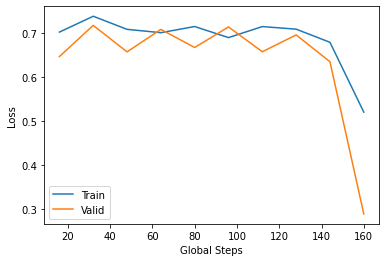

In [27]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /home/jovyan/playground/projects/TREC2021/NewsTrack/temporal_classifier/model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     1.0000    0.7500    0.8571         4
           0     0.8889    1.0000    0.9412         8

    accuracy                         0.9167        12
   macro avg     0.9444    0.8750    0.8992        12
weighted avg     0.9259    0.9167    0.9132        12



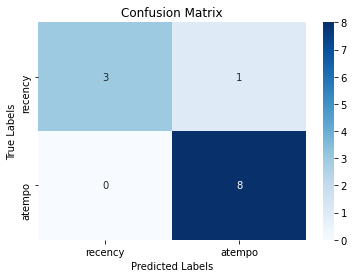

In [29]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (query,labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                query = query.type(torch.LongTensor)  
                query = query.to(device)
                output = model(query, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['recency', 'atempo'])
    ax.yaxis.set_ticklabels(['recency', 'atempo'])
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

In [9]:
# TabularDataset


topics = TabularDataset(path='../Data/Topic/trec2021/topic2021.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

topic_iter = BucketIterator(topics, batch_size=4, sort_key=lambda x: len(x.query),
                            device=device, train=True, sort=True, sort_within_batch=True)

In [11]:
# Estimate function

def estimate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (query,labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                query = query.type(torch.LongTensor)  
                query = query.to(device)
                output = model(query, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    return y_pred
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

labels = estimate(best_model, topic_iter)
labels

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /home/jovyan/playground/projects/TREC2021/NewsTrack/temporal_classifier/model/model.pt


[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1]

In [12]:
len(labels)

51

In [13]:
topic = pd.read_csv("../Data/Topic/trec2021/topic2021.csv")

In [14]:
topic["label"] = pd.Series(labels)

In [15]:
temporaltopics = topic["query"].loc[topic["label"] == 1]

In [16]:
for i in temporaltopics:
    print(i)

What can I do as a woman to lessen my chances of getting dementia?
I'm looking for information pertaining to Ethiopia's Abiy Ahmed's winning of the Nobel Peace Prize.
What issues face the approximately 28% of Americans with limited or no access to traditional banks?
Find information about increasing numbers of coyotes in suburban Maryland and any impacts on other species.
Japan is backing it's magnetic-levitation railroad technology in the US.
I'm looking for information about the prevalence of marathon runners who cheat.
Invasive species are a growing problem in the US
Is climate change affecting the cicada cycles?
Critics claim that efforts to shut down the Diversity Visa lottery aka the green card lottery designed for family unification and replace it with a 'merit-based lottery' is unfair.
How accurate was the 2020 reporting of COVID-19 in Mexico?
Why does the United States consistently lag in global literacy?


In [17]:
# merge the classidtion results to query files
queries = pd.read_csv("../Data/Topic/trec2021/topicquery.csv")
queries['IsTempo']=''
for i in tqdm(range(len(queries))):
    queries.at[i,'IsTempo'] = topic['label'].loc[topic['query'] == queries['desc'][i]].item()


topic.to_csv("../Data/Topic/trec2021/clsquery.csv",index=False)